In [1]:
import gym
import numpy as np
import matplotlib.pylab as plt
import random
import math
import tensorflow as tf

In [ ]:
env_name = gym.make('MountainCar-v0')

In [ ]:
env_name.action_space

In [5]:
env_name.reset()
for _ in range(1000):
    env_name.render()
    env_name.step(env_name.action_space.sample()) # take a random action

In [4]:
env_name.reset()
env_name.step(2)

(array([-4.32255304e-01,  3.25818646e-04]), -1.0, False, {})

In [2]:
class Model:
    def __init__(self, num_states, num_actions, batch_size):
        self._num_states = num_states
        self._num_actions = num_actions
        self._batch_size = batch_size
        # define the placeholders
        self._states = None
        self._actions = None
        # the output operations
        self._logits = None
        self._optimizer = None
        self._var_init = None
        # now setup the model
        self._define_model()

    def _define_model(self):
        self._states = tf.placeholder(shape=[None, self._num_states], dtype=tf.float32)
        self._q_s_a = tf.placeholder(shape=[None, self._num_actions], dtype=tf.float32)
        # create a couple of fully connected hidden layers
        fc1 = tf.layers.dense(self._states, 50, activation=tf.nn.relu)
        fc2 = tf.layers.dense(fc1, 50, activation=tf.nn.relu)
        self._logits = tf.layers.dense(fc2, self._num_actions)
        loss = tf.losses.mean_squared_error(self._q_s_a, self._logits)
        self._optimizer = tf.train.AdamOptimizer().minimize(loss)
        self._var_init = tf.global_variables_initializer()
        
    def predict_one(self, state, sess):
        return sess.run(self._logits, feed_dict={self._states:
                                                 state.reshape(1, self._num_states)})

    def predict_batch(self, states, sess):
        return sess.run(self._logits, feed_dict={self._states: states})

    def train_batch(self, sess, x_batch, y_batch):
        sess.run(self._optimizer, feed_dict={self._states: x_batch, self._q_s_a: y_batch})

In [3]:
class Memory:
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)

In [4]:
class GameRunner:
    def __init__(self, sess, model, env, memory, max_eps, min_eps,
                 decay, render=True):
        self._sess = sess
        self._env = env
        self._model = model
        self._memory = memory
        self._render = render
        self._max_eps = max_eps
        self._min_eps = min_eps
        self._decay = decay
        self._eps = self._max_eps
        self._steps = 0
        self._reward_store = []
        self._max_x_store = []
        
    def run(self):
        state = self._env.reset()
        tot_reward = 0
        max_x = -100
        while True:
            if self._render:
                self._env.render()
    
            action = self._choose_action(state)
            next_state, reward, done, info = self._env.step(action)
            if next_state[0] >= 0.1:
                reward += 10
            elif next_state[0] >= 0.25:
                reward += 20
            elif next_state[0] >= 0.5:
                reward += 100
    
            if next_state[0] > max_x:
                max_x = next_state[0]
            # is the game complete? If so, set the next state to
            # None for storage sake
            if done:
                next_state = None
    
            self._memory.add_sample((state, action, reward, next_state))
            self._replay()
    
            # exponentially decay the eps value
            self._steps += 1
            self._eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) \
                                      * math.exp(-LAMBDA * self._steps)
    
            # move the agent to the next state and accumulate the reward
            state = next_state
            tot_reward += reward
    
            # if the game is done, break the loop
            if done:
                self._reward_store.append(tot_reward)
                self._max_x_store.append(max_x)
                break
    
        print("Step {}, Total reward: {}, Eps: {}".format(self._steps, tot_reward, self._eps))
        
    def _choose_action(self, state):
        if random.random() < self._eps:
            return random.randint(0, self._model._num_actions - 1)
        else:
            return np.argmax(self._model.predict_one(state, self._sess))
        
    def _replay(self):
        batch = self._memory.sample(self._model._batch_size)
        states = np.array([val[0] for val in batch])
        next_states = np.array([(np.zeros(self._model._num_states)
                                 if val[3] is None else val[3]) for val in batch])
        # predict Q(s,a) given the batch of states
        q_s_a = self._model.predict_batch(states, self._sess)
        # predict Q(s',a') - so that we can do gamma * max(Q(s'a')) below
        q_s_a_d = self._model.predict_batch(next_states, self._sess)
        # setup training arrays
        x = np.zeros((len(batch), self._model._num_states))
        y = np.zeros((len(batch), self._model._num_actions))
        for i, b in enumerate(batch):
            state, action, reward, next_state = b[0], b[1], b[2], b[3]
            # get the current q values for all actions in state
            current_q = q_s_a[i]
            # update the q value for action
            if next_state is None:
                # in this case, the game completed after action, so there is no max Q(s',a')
                # prediction possible
                current_q[action] = reward
            else:
                current_q[action] = reward + GAMMA * np.amax(q_s_a_d[i])
            x[i] = state
            y[i] = current_q
        self._model.train_batch(self._sess, x, y)

/Users/jcbcnc/anaconda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 1 of 300
Step 200, Total reward: -200.0, Eps: 0.9803966865736877
Step 400, Total reward: -200.0, Eps: 0.9611815447608
Step 600, Total reward: -200.0, Eps: 0.9423468882484062
Step 800, Total reward: -200.0, Eps: 0.9238851829227694
Step 1000, Total reward: -200.0, Eps: 0.9057890438555999
Step 1200, Total reward: -200.0, Eps: 0.888051232349986
Step 1400, Total reward: -200.0, Eps: 0.8706646530448178
Step 1600, Total reward: -200.0, Eps: 0.8536223510765493
Step 1800, Total reward: -200.0, Eps: 0.8369175092971592
Step 2000, Total reward: -200.0, Eps: 0.820543445547202
Episode 11 of 300
Step 2200, Total reward: -200.0, Eps: 0.8044936099828537
Step 2400, Total reward: -200.0, Eps: 0.7887615824558878
Step 2600, Total reward: -200.0, Eps: 0.7733410699455306
Step 2800, Total reward: -200.0, Eps: 0.7582259040411682
Step 3000, Total reward: -200.0, Eps: 0.7434100384749007
Step 3200, Total rew

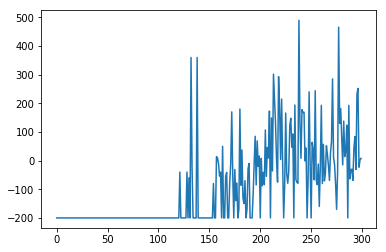

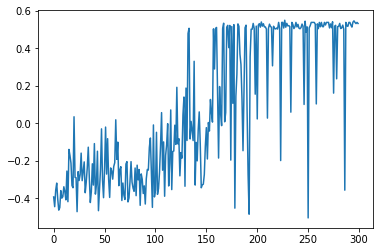

In [5]:
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.0001
GAMMA = 0.99
BATCH_SIZE = 50
if __name__ == "__main__":
    env_name = 'MountainCar-v0'
    env = gym.make(env_name)

    num_states = env.env.observation_space.shape[0]
    num_actions = env.env.action_space.n

    model = Model(num_states, num_actions, BATCH_SIZE)
    mem = Memory(50000)

    with tf.Session() as sess:
        sess.run(model._var_init)
        gr = GameRunner(sess, model, env, mem, MAX_EPSILON, MIN_EPSILON,
                        LAMBDA)
        num_episodes = 300
        cnt = 0
        while cnt < num_episodes:
            if cnt % 10 == 0:
                print('Episode {} of {}'.format(cnt+1, num_episodes))
            gr.run()
            cnt += 1
        plt.plot(gr._reward_store)
        plt.show()
        plt.close("all")
        plt.plot(gr._max_x_store)
        plt.show()